In [1]:
%matplotlib inline
!pip install thop

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from thop import profile
from torchsummary import summary


# training a model first

In [2]:
use_cuda = True
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # Define what device we are using
# print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
list(range(5,0,-1))

[5, 4, 3, 2, 1]

In [5]:

def find_res_fixed_params(N, C1, K1, B1, K3, P1, S1, Q1, R1):
  '''
    Keeping the number of parameters the same
    Approach III in the paper
  '''
  # N1=20 # orig image size

  # # layer 1
  # C1=3 # filter size old
  # K1=20  # num filters old
  # P1=0 # padding old
  # S1=1 # stride old

  # layer 2
  # B1=2 # filter size old
  # K3=10 # num filters old	
  # Q1=0 # padding old
  # R1=1 # stride old

  num_solutions = 0 
  Solutions = []

  # for C1 in np.arange(3,N1/2,2): # filter size old
  for N2 in np.arange(N1+1,29): # new img resolution
    # for B1 in np.arange(2,N2/2): # filter size old
      for K2 in np.arange(K1,5,-1): # new number of filters in layer 1
        for P2 in np.arange(P1,10): # new padding size in layer 1
          for S2 in np.arange(S1,10): # new stride in layer 1
            ratio = np.sqrt(K1/K2)				
            if np.int(ratio) != ratio: continue
            C2 = ratio * C1

            M2 = (N2 - C2 + 2*P2)  / S2  
            M1 = (N1 - C1 + 2*P1)  / S1
            if M2 != M1: continue

            # 2nd layer
            # for Q2 in np.arange(Q1,5): # new padding size in layer 2
            #   for R2 in np.arange(R1,5): # new stride size in layer 2
            for Q2 in np.arange(10): # new padding size in layer 2
              for R2 in np.arange(1,10): # new stride size in layer 2

                B2 = ratio * B1 
                if np.int(B2) != B2: continue	
                if (M2 - B2 + 2*Q2)  / R2  !=  (M1 - B1 + 2*Q1)  / R1: continue
                M3 = (M2 - B2 + 2*Q2)  / R2 

                if B2 > M2/2: continue								

                # print(f'found a solution {C1}, {B1}, {N2}, {K2}, {P2}, {S1}, {B2}, {Q2}, {R2}')

                # print(f'1st layer old: inp res: {N1}, filter size: {C1}, num filters: {K1}, out res: {M1}, stride: {S1}, pad: {P1}')
                # print(f'1st layer new: inp res: {N2}, filter size: {C2}, num filters: {K2}, out res: {M2}, stride: {S2}, pad: {P2}')
                # print(f'2nd layer old: inp res: {M1}, filter size: {B1}, out res: {M3}, stride: {R1}, pad: {Q1}')
                # print(f'2nd layer new: inp res: {M1}, filter size: {B2}, out res: {M3}, stride: {R2}, pad: {Q2}\n')
                params_old = (K1 * C1**2 * 1) + (K3 * B1**2 * K1) 
                params_new = (K2 * C2**2 * 1) + (K3 * B2**2 * K2) 

                assert params_old==params_new, False
                # print(f'PARAMs old: {params_old}, PARAMs new: {params_new}\n')

                num_solutions += 1
                Solutions.append({'im_res_orig':N1, 'im_res_new':N2, 'layer1_old':[C1, K1, S1, P1], 'layer2_old':[B1, K3, R1, Q1], 'layer1':[C2, K2, S2, P2], 'layer2':[B2, K3, R2, Q2]})

  # print(f'num solutions: {num_solutions}')
  return Solutions

In [7]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img


class NetTest(nn.Module):
    def __init__(self, im_res=28, conv1_size=5, conv2_size=5, pool1_size=2, pool2_size=2, num_conv1=10, num_conv2=10, stride_1=1, stride_2=1, padd_1=0, padd_2=0, num_hid=50):
        super(NetTest, self).__init__()
        # import pdb; pdb.set_trace()
        self.conv1 = nn.Conv2d(1, num_conv1, kernel_size=conv1_size, stride=stride_1, padding=padd_1, bias=False)
        self.res1 = int((im_res - conv1_size + 2*padd_1) / stride_1 + 1)
        self.conv2 = nn.Conv2d(num_conv1, num_conv2, kernel_size=conv2_size, stride=stride_2, padding=padd_2, bias=False)
        self.res2_pool = int((self.res1 - pool1_size + 2*0) / pool1_size + 1)                
        self.res2_conv = int((self.res2_pool - conv2_size + 2*padd_2) / stride_2 + 1 )       
        self.res2_pool = int((self.res2_conv - pool2_size + 2*0) / pool2_size + 1)               
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear((self.res2_pool**2)*num_conv2, num_hid, bias=False)        
        self.fc2 = nn.Linear(num_hid, 10, bias=False)
        self.pool1_size = pool1_size
        self.pool2_size = pool2_size
        self.num_conv2 = num_conv2
        self.im_res = im_res

        
    def forward(self, x):
        # import pdb; pdb.set_trace()
        # x = F.avg_pool2d(x, kernel_size=28//self.im_res)
        # x = F.avg_pool2d(x, kernel_size=2, padding=6, stride=2)
        # x = cv2.resize(x, (self.im_res, self.im_res)) 

        # xx = torch.stack((x[0,0],x[0,0], x[0,0]), axis=2)
        # img_pil = array_to_img(xx.cpu())
        # img_pil = img_pil.resize((self.im_res,self.im_res))
        # x = torch.tensor(img_to_array(img_pil)).cuda()
        # x = x[:,:,0][None,None] #.permute(2,0,1)

        tmp1 = F.relu(F.max_pool2d(self.conv1(x), self.pool1_size))
        tmp = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(tmp1)), self.pool2_size))
        # x = F.avg_pool2d(tmp, kernel_size=tmp.shape[-1])
        # x = x[:,:,0,0]

        x = tmp.view(-1, (self.res2_pool**2)*self.num_conv2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x   ### SUPER IMPORTANT ***************************** works with cross entropy loss loss now

device = 'cuda'

In [95]:
# c = 6
# p = 3
# s = 2
# assert 20 == (28 - c + 2*p) / s + 1, False
# 19 = 22 + 2*6 
# import cv2


In [8]:
def train_model(model):

  EPOCHS = 10
  losses = []

  optimizer = optim.Adadelta(model.parameters())

  model.train()
  for epoch in range(EPOCHS):
      for batch_idx, (data, target) in enumerate(train_loader):
          
          data, target = data.to(device), target.to(device)        
          optimizer.zero_grad()
          y_pred = model(data) 

          # import pdb; pdb.set_trace()
          loss = F.cross_entropy(y_pred, target)
          losses.append(loss.cpu().data)

          loss.backward()
          optimizer.step()
          
          # Display
          if batch_idx % 100 == 1:
              print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch+1,
                  EPOCHS,
                  batch_idx * len(data), 
                  len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), 
                  loss.cpu().data), 
                  end='')

  # Eval
  # model.eval()
  # Eval
  model.eval()
  correct = total = 0
  for idx, (images, labels) in enumerate(test_loader):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      _, pre = torch.max(outputs.data, 1)

      total += len(labels)
      correct += (pre == labels).sum()

  accuracy = float(correct) / total
  print('Test Accuracy: %f %%' % accuracy)
  # return acc


  # import pdb; pdb.set_trace()
  # evaluate_x = test_loader.dataset.test_data.type_as(torch.FloatTensor()).to(device)
  # evaluate_y = test_loader.dataset.test_labels.to(device)

  # output = model(evaluate_x[:,None,...])
  # pred = output.data.max(1)[1]
  # d = pred.eq(evaluate_y.data).cpu()
  # accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
  
  print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
      epoch+1,
      EPOCHS,
      len(train_loader.dataset), 
      len(train_loader.dataset),
      100. * batch_idx / len(train_loader), 
      loss.cpu().data,
      accuracy*100,
      end=''))
  

  return accuracy

In [9]:
# sol_3

In [18]:
def evaluate_orig_model(sol):

  # run the original model for a couple of times
  # sol = sol_3[0]
  sol['orig_solutions'] = []

  im_res = sol['im_res_orig']
  cv1_size = int(sol['layer1_old'][0])
  cv2_size = int(sol['layer2_old'][0])
  no_conv1 = sol['layer1_old'][1]
  no_conv2 = sol['layer2_old'][1]
  st1 = sol['layer1_old'][2]
  st2 = sol['layer2_old'][2]
  pd1 = sol['layer1_old'][3]
  pd2 = sol['layer2_old'][3]

  global train_loader
  global test_loader
  
  train_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST('../data', train=True, download=True, transform=transforms.Compose([
              transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)

  test_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
              transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)

  # for run_no in range(1):
  try:
    # print(f'----  im_res={im_res_new}, conv1_size={cv1_size}, conv2_size={cv2_size}')
    # import pdb; pdb.set_trace()
    accs = []
    for i in range(3):
      model = NetTest(im_res=im_res, conv1_size=cv1_size, conv2_size=cv2_size, num_conv1=no_conv1, num_conv2=no_conv2, padd_1=pd1, padd_2=pd2, stride_1=st1, stride_2=st2).to(device)
      if i==0:
        macs, params = profile(model, inputs=(torch.randn(1, 1, im_res, im_res).to(device), ))
      accs.append(train_model(model))
    
    sol['orig_solutions'].append((macs, params, np.mean(accs)))
    # accuracies.append((sol, macs, params, acc))
    # print(accuracies[-1])
    print(sol, '\n')

  except:
    print('\n Model invalid')


  return #sol


In [30]:
def evaluate_new_model(sols):
  # running the solutions; one by one; three each
  # for run_no

  for sol in sols:
        im_res = sol['im_res_new']
        cv1_size = int(sol['layer1'][0])
        cv2_size = int(sol['layer2'][0])
        no_conv1 = sol['layer1'][1]
        no_conv2 = sol['layer2'][1]
        st1 = sol['layer1'][2]
        st2 = sol['layer2'][2]
        pd1 = sol['layer1'][3]
        pd2 = sol['layer2'][3]

        sol['new_solutions'] = []

        global train_loader
        global test_loader

        train_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST('../data', train=True, download=True, transform=transforms.Compose([
                    transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)

        test_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
                    transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)


        # for run_no in range(1):
        try:
          # print(f'----  im_res={im_res_new}, conv1_size={cv1_size}, conv2_size={cv2_size}')
          
          accs = []
          for i in range(3):
            model = NetTest(im_res=im_res, conv1_size=cv1_size, conv2_size=cv2_size, num_conv1=no_conv1, num_conv2=no_conv2, padd_1=pd1, padd_2=pd2, stride_1=st1, stride_2=st2).to(device)
            if i==0:
              macs, params = profile(model, inputs=(torch.randn(1, 1, im_res, im_res).to(device), ))
            accs.append(train_model(model))
          
          # which_model = 'new_res' if a else 'orig_res'
          # sol[which_model] = (macs, params, acc)
          sol['new_solutions'].append((macs, params, np.mean(accs)))
          # accuracies.append((sol, macs, params, acc))
          # print(accuracies[-1])
          print(sol, '\n')

        except:
          print('\n Model invalid')

  
  return #sols

In [20]:
# np.arange(3,8,2)

In [ ]:
import random 
all_res = {}

for N1 in [12]:#12,16,20,24]:
  all_solutions = []
  for C1 in np.arange(3,8,2): # filter size layer 1 
    for K1 in np.arange(10,21,5): # num filters layer 1   
      for B1 in np.arange(3,8,2): # filter size layer 2 
        for K3 in np.arange(10,21,5): # num filters layer 2    
          for P1 in np.arange(2): # padding layer 1
            for S1 in np.arange(1,2): # stride layer 1    
              for Q1 in np.arange(2): # padding layer 2
                for R1 in np.arange(1,2): # stride layer 2   
                  xx = find_res_fixed_params(N1, C1, K1, B1, K3, P1, S1, Q1, R1)
                  if xx:
                    all_solutions.append(xx)
  
  results = []
  random.shuffle(all_solutions)
  all_solutions.sort(key=len, reverse=True)
  all_solutions = all_solutions[:10]
  for idx, sol_3 in enumerate(all_solutions):
    print(f'\n --------------------- solution no {idx} -------------------- \n')
    evaluate_orig_model(sol_3[0])
    if not sol_3[0]['orig_solutions']:
      break

    if len(sol_3) > 4:
      sol_3 = sol_3[:4]

    evaluate_new_model(sol_3)
    xx = (sol_3[0]['orig_solutions'][0], [sol['new_solutions'][0][-1] for sol in sol_3 if sol['new_solutions']])

    results.append(xx)

  all_res[N1] = results          
print(len(all_solutions))


 --------------------- solution no 0 -------------------- 

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.dropout.Dropout2d'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.NetTest'>. Treat it as zero Macs and zero Params.
 Train Epoch: 10/10 [50100/60000 (84%)]	Loss: 1.187976Test Accuracy: 0.723300 %
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 1.003042	 Test Accuracy: 72.3300%
 Train Epoch: 10/10 [50100/60000 (84%)]	Loss: 0.966386Test Accuracy: 0.771900 %
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.947134	 Test Accuracy: 77.1900%
 Train Epoch: 10/10 [50100/60000 (84%)]	Loss: 1.047571Test Accuracy: 0.756200 %
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 1.061970	 Test Accuracy: 75.6200%
{'im_res_orig': 12, 'im_res_new': 13, 'layer1_old': [5, 10, 1, 0], 'layer2_old': [3, 15, 1, 0], 

In [29]:
# ([len(x) for x in all_solutions])
sol_3
# 
# len(all_solutions)



# all_res[N1]

[{'im_res_new': 13,
  'im_res_orig': 12,
  'layer1': [5.0, 10, 2, 3],
  'layer1_old': [5, 10, 1, 0],
  'layer2': [3.0, 10, 1, 0],
  'layer2_old': [3, 10, 1, 0],
  'new_solutions': [(20600.0, 2150.0, 0.7579333333333333)],
  'orig_solutions': [(20600.0, 2150.0, 0.6956000000000001)]},
 {'im_res_new': 13,
  'im_res_orig': 12,
  'layer1': [5.0, 10, 2, 3],
  'layer1_old': [5, 10, 1, 0],
  'layer2': [3.0, 10, 2, 2],
  'layer2_old': [3, 10, 1, 0],
  'new_solutions': [(25100.0, 2150.0, 0.7218999999999999)]},
 {'im_res_new': 13,
  'im_res_orig': 12,
  'layer1': [5.0, 10, 2, 3],
  'layer1_old': [5, 10, 1, 0],
  'layer2': [3.0, 10, 3, 4],
  'layer2_old': [3, 10, 1, 0],
  'new_solutions': [(32900.0, 3650.0, 0.7961333333333332)]},
 {'im_res_new': 13,
  'im_res_orig': 12,
  'layer1': [5.0, 10, 2, 3],
  'layer1_old': [5, 10, 1, 0],
  'layer2': [3.0, 10, 4, 6],
  'layer2_old': [3, 10, 1, 0],
  'new_solutions': [(32900.0, 3650.0, 0.7776666666666667)]},
 {'im_res_new': 13,
  'im_res_orig': 12,
  'layer1'

In [104]:
all_solutions[2]

[{'im_res_new': 27,
  'im_res_orig': 24,
  'layer1': [3.0, 10, 2, 9],
  'layer1_old': [3, 10, 1, 0],
  'layer2': [3.0, 15, 1, 0],
  'layer2_old': [3, 15, 1, 0]},
 {'im_res_new': 27,
  'im_res_orig': 24,
  'layer1': [3.0, 10, 2, 9],
  'layer1_old': [3, 10, 1, 0],
  'layer2': [3.0, 15, 2, 9],
  'layer2_old': [3, 15, 1, 0]}]

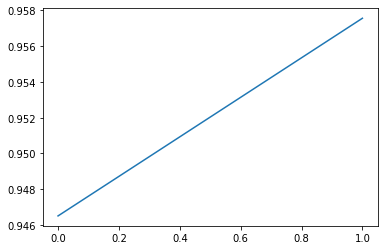

In [ ]:
for k in all_res.keys():
  means = np.mean(np.array([(x[-1],np.max(y)) for x,y in all_res[k]]), axis=0)
  # stds = np.std(np.array([(x[0][-1],np.max(y)) for x,y in all_res[k] ]), axis=0)
  plt.plot(means)

In [ ]:
means

array([0.94651, 0.95756])

In [ ]:
for k in all_res.keys():
  means = np.mean(np.array([(x[0][-1],y) for x,y in all_res[k] ]), axis=0)
  stds = np.std(np.array([(x[0][-1],y) for x,y in all_res[k] ]), axis=0)
  plt.plot(means)


In [ ]:
sol_3

In [ ]:
# FLOPS
# http://www.bnikolic.co.uk/blog/python/flops/2019/10/01/pytorch-count-flops.html

In [ ]:
aa = {2:'a'}

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
colors = ['blue', 'red', 'green', ]
for idx,i in enumerate([7,14,28]):
  plt.plot(np.log(pars[ress==i]), score[ress==i] , 'o', color = colors[idx])

plt.legend(['res = 7', 'res = 14', 'res = 28'])

In [ ]:
colors = ['blue', 'red', 'green', ]
for idx,i in enumerate([7,14,28]):
  plt.plot(np.log(flops[ress==i]), score[ress==i] , 'o', color = colors[idx])

plt.legend(['res = 7', 'res = 14', 'res = 28'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ls MyDrive/

In [ ]:
cd drive/

In [ ]:
# cd /MyDrive/classification_images/Pairwise
!cd MyDrive/ClassificationImages/Pairwise/

In [ ]:
# from google.colab import files
# # 
# with open('example.txt', 'w') as f:
#   f.write('some content')

# files.download('example.txt')



# with open('MyDrive/ClassificationImages/Pairwise/accs_mnist.npz', 'w') as f:
np.savez('MyDrive/ClassificationImages/Pairwise/accs_fmnist.npz', accs)


In [ ]:
# with open('MyDrive/ClassificationImages/Pairwise/accs_mnist.npz') as f:
dd = np.load('MyDrive/ClassificationImages/Pairwise/accs_mnist.npz')

In [ ]:
# accs = dd['arr_0']

In [ ]:
def test_f(aa):
  aa.append(10)

  return

q = [1]
test_f(q)
print(q)
